In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import datetime
import copy
from collections import deque
from scipy.stats import skew, kurtosis
from collections import deque
import matplotlib as plt

In [ ]:
TICKERS = ["MSFT", "AAPL", "NVDA", "AMZN", "GOOG", "META", "TSLA"]

# IPO dates for each (approximate). We'll start at max(1981-01-01, actual IPO).
# For example (you can refine these from known listings):
IPO_DATES = {
    "AAPL": "1980-12-12",
    "MSFT": "1986-03-13",
    "NVDA": "1999-01-22",
    "AMZN": "1997-05-15",
    "GOOG": "2004-08-19",
    "META": "2012-05-18",
    "TSLA": "2010-06-29"
}

START_DATE = "1981-01-01"
END_DATE = "2023-12-31"

INITIAL_CAPITAL = 1_000_000.0

# Commission = 0.10% = 0.0010
# Slippage  = 0.02% = 0.0002
COMMISION = 0.0010
SLIPPAGE = 0.0002

MIN_SHARES_PER_TRADE = 10
MAX_WEIGHT_PER_STOCK = 0.30   # 30% of portfolio

RISK_FREE_RATE = 0.02
TRADING_DAYS_PER_YEAR = 252

RSI_PERIOD = 14

In [ ]:
def download_adjusted_data(ticker, start_date, end_date):
    df = yf.download(
        ticker,
        start=start_date,
        end=end_date,
        auto_adjust=True
    )

    if isinstance(df.columns, pd.MultiIndex):
        df.columns = [tup[0] for tup in df.columns]

    df.dropna(inplace=True)
    return df

def compute_rsi(series, period=14):
    # Get the difference in price from previous step
    delta = series.diff()

    # Make the positive gains (up) and negative gains (down) Series
    up = np.where(delta > 0, delta, 0.0)
    down = np.where(delta < 0, -delta, 0.0)


    # Exponential Moving Average or Simple
    # Here we use simple averages for Gains & Losses
    roll_up = pd.Series(up, index=series.index).rolling(period).mean()
    roll_down = pd.Series(down, index=series.index).rolling(period).mean()

    RS = roll_up / roll_down
    RSI = 100.0 - (100.0 / (1.0 + RS))

    # Avoid division-by-zero if `roll_down` is zero
    # Prevents inf and/or nan values
    RSI[:] = np.select([roll_down == 0, roll_up == 0, True], [100, 0, RSI])

    # Assert range
    # Note: rsi[:length - 1] is excluded from above assertion because it is NaN for SMA.
    valid_rsi = RSI[period - 1:]
    assert ((0 <= valid_rsi) & (valid_rsi <= 100)).all()

    return pd.Series(RSI, index=series.index)

def get_signals(rsi_series, lower=25, upper=75):
    signals = pd.Series(index=rsi_series.index, dtype=np.int64).fillna(0)

    signals[rsi_series < lower] = 1
    signals[rsi_series > upper] = -1
    signals = signals.fillna(0)
    return signals

In [ ]:
dfs = {}

for ticker in TICKERS:
    actual_start = max(pd.to_datetime(START_DATE),
                       pd.to_datetime(IPO_DATES[ticker]))
    df = download_adjusted_data(ticker, actual_start, END_DATE)
    df["RSI"] = compute_rsi(df["Close"], RSI_PERIOD)
    df["Signal"] = get_signals(df["RSI"], 25, 75)
    dfs[ticker] = df

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [ ]:
def get_all_trading_dates(dfs, tickers):
    return sorted(set(date for ticker in tickers for date in dfs[ticker].index))

def get_daily_signals_and_prices(dfs, tickers, today, tomorrow):
    signals = {}
    today_close = {}
    tomorrow_open = {}

    for ticker in tickers:
        df = dfs[ticker]
        signals[ticker] = df.at[today, "Signal"] if today in df.index else 0
        today_close[ticker] = df.at[today, "Close"] if today in df.index else np.nan
        tomorrow_open[ticker] = df.at[tomorrow, "Open"] if tomorrow in df.index else np.nan

    return signals, today_close, tomorrow_open

def compute_portfolio_value(cash, positions, prices):
    return cash + sum(
        positions[tkr] * prices[tkr]
        for tkr in positions if not np.isnan(prices[tkr])
    )

def execute_sell_trades(positions, cash, tomorrow_open, signals, trade_log, tomorrow):
    for tkr, signal in signals.items():
        # there is signal + more than 10 share + theres price for tommorow open
        if signal == -1 and positions[tkr] >= MIN_SHARES_PER_TRADE and not np.isnan(tomorrow_open[tkr]):
            shares = positions[tkr]
            price = tomorrow_open[tkr]
            proceeds = (shares * price * (1 - SLIPPAGE)) * (1 - COMMISION)
            cash += proceeds
            trade_log.append({
                "date": tomorrow,
                "ticker": tkr,
                "action": "SELL",
                "shares": shares,
                "fill_price": price,
                "cash_change": proceeds
            })
            positions[tkr] = 0
    return cash

def execute_buy_trades(positions, cash, tomorrow_open, signals, trade_log, tomorrow, max_weight=0.3):
    buy_tickers = [tkr for tkr, sig in signals.items() if sig == 1]
    held_tickers = [tkr for tkr, shares in positions.items() if shares > 0]
    tickers_to_hold = list(set(buy_tickers + held_tickers))

    if not tickers_to_hold:
        return cash, positions

    num_tickers = len(tickers_to_hold)
    weight = min(1.0 / num_tickers, max_weight)

    portfolio_value = compute_portfolio_value(cash, positions, tomorrow_open)
    target_allocation = {tkr: portfolio_value * weight for tkr in tickers_to_hold}
    shares_allocation = {
        tkr: portfolio_value // tomorrow_open[tkr]
        for tkr in tickers_to_hold if not np.isnan(tomorrow_open.get(tkr, np.nan))
    }
    shares_allocation_sorted = dict(
        sorted(shares_allocation.items(), key=lambda item: item[1], reverse=True)
    )

    for tkr, shares in shares_allocation_sorted.items():
        price = tomorrow_open[tkr]

        if np.isnan(price) or price == 0:
            continue

        target_shares = shares
        current_shares = positions.get(tkr, 0)
        delta_shares = target_shares - current_shares

        if abs(delta_shares) <= 10: # not enough shares to perform a trade
            continue

        if delta_shares >= 10: # need to buy
            cost = delta_shares * price * (1 + SLIPPAGE) * (1 + COMMISION)
            if cost <= cash:
                positions[tkr] += delta_shares
                cash -= cost
                trade_log.append({
                    "date": tomorrow,
                    "ticker": tkr,
                    "action": "BUY",
                    "shares": delta_shares,
                    "fill_price": price,
                    "cash_change": -cost
                })
            else: # buy as much as possible
                affordable = cash // (price * (1 + SLIPPAGE) * (1 + COMMISION))
                if affordable >= 10:
                    cost = affordable * price * (1 + SLIPPAGE) * (1 + COMMISION)
                    positions[tkr] += affordable
                    cash -= cost
                    trade_log.append({
                        "date": tomorrow,
                        "ticker": tkr,
                        "action": "BUY",
                        "shares": affordable,
                        "fill_price": price,
                        "cash_change": -cost
                    })

        elif delta_shares <= -10: # need to sell
            shares_to_sell = -delta_shares
            proceeds = shares_to_sell * price * (1 - SLIPPAGE) * (1 - COMMISION)
            positions[tkr] -= shares_to_sell
            cash += proceeds
            trade_log.append({
                "date": tomorrow,
                "ticker": tkr,
                "action": "SELL",
                "shares": shares_to_sell,
                "fill_price": price,
                "cash_change": proceeds
            })

    return cash, positions

def run_backtest(dfs, tickers, initial_capital):
    positions = {ticker: 0 for ticker in tickers}
    cash = initial_capital
    portfolio_values = []
    dates_traded = []
    trade_log = []
    positions_over_time = []

    all_dates = get_all_trading_dates(dfs, tickers)

    for i in range(len(all_dates) - 1):
        today, tomorrow = all_dates[i], all_dates[i+1]
        signals, today_close, tomorrow_open = get_daily_signals_and_prices(dfs, tickers, today, tomorrow)

        portfolio_val_today = compute_portfolio_value(cash, positions, today_close)
        portfolio_values.append(portfolio_val_today)
        positions_over_time.append(copy.deepcopy(positions))
        dates_traded.append(today)

        cash = execute_sell_trades(positions, cash, tomorrow_open, signals, trade_log, tomorrow)
        cash, positions = execute_buy_trades(positions, cash, tomorrow_open, signals, trade_log, tomorrow)

    # Final valuation
    final_date = all_dates[-1]
    final_value = cash + sum(
        positions[tkr] * dfs[tkr].at[final_date, "Close"]
        for tkr in tickers
        if final_date in dfs[tkr].index
    )
    portfolio_values.append(final_value)
    dates_traded.append(final_date)

    return portfolio_values, dates_traded, positions_over_time, trade_log

In [ ]:
portfolio_values, dates_traded, positions_over_time, trade_log = run_backtest(dfs, TICKERS, INITIAL_CAPITAL)

In [ ]:
def calculate_portfolio_metrics(
    portfolio_series,
    dates_traded,
    trade_log
):
    daily_returns = portfolio_series.pct_change().dropna()
    final_value = portfolio_series.iloc[-1]

    total_return = (final_value / INITIAL_CAPITAL - 1) * 100
    num_years = len(dates_traded) / TRADING_DAYS_PER_YEAR
    cagr = ((final_value / INITIAL_CAPITAL) ** (1 / num_years)) - 1

    rolling_max = portfolio_series.cummax()
    drawdowns = (portfolio_series - rolling_max) / rolling_max
    max_drawdown = drawdowns.min()
    calmar_ratio = cagr / abs(max_drawdown) if max_drawdown != 0 else np.nan

    def get_period_return(series):
        return (series[-1] / series[0] - 1) * 100 if len(series) > 0 else np.nan

    now = portfolio_series.index[-1]
    periods = {
        "MTD": now - pd.DateOffset(months=1),
        "3m": now - pd.DateOffset(months=3),
        "6m": now - pd.DateOffset(months=6),
        "YTD": pd.Timestamp(f"{now.year}-01-01"),
        "1Y": now - pd.DateOffset(years=1),
        "3Y (ann.)": now - pd.DateOffset(years=3),
        "5Y (ann.)": now - pd.DateOffset(years=5),
        "10Y (ann.)": now - pd.DateOffset(years=10),
    }

    period_returns = {}
    for label, start in periods.items():
        sliced = portfolio_series[portfolio_series.index >= start]
        if "ann." in label and len(sliced) > 1:
            annualized = ((sliced[-1] / sliced[0]) ** (1 / (len(sliced) / TRADING_DAYS_PER_YEAR))) - 1
            period_returns[label] = annualized * 100
        else:
            period_returns[label] = get_period_return(sliced)

    # Daily stats
    daily_rf = RISK_FREE_RATE / 252
    excess_daily = daily_returns - daily_rf
    sharpe_daily = excess_daily.mean() / daily_returns.std()
    sortino_daily = excess_daily.mean() / daily_returns[daily_returns < 0].std()
    mean_daily_ann = daily_returns.mean() * 252
    vol_daily_ann = daily_returns.std() * np.sqrt(252)
    skew_daily = daily_returns.skew()
    kurt_daily = daily_returns.kurtosis()
    best_day = daily_returns.max() * 100
    worst_day = daily_returns.min() * 100

    # Monthly stats
    monthly_series = portfolio_series.resample("ME").last()
    monthly_returns = monthly_series.pct_change().dropna()
    monthly_rf = RISK_FREE_RATE / 12
    excess_monthly = monthly_returns - monthly_rf
    sharpe_monthly = excess_monthly.mean() / monthly_returns.std()
    sortino_monthly = excess_monthly.mean() / monthly_returns[monthly_returns < 0].std()
    mean_monthly_ann = monthly_returns.mean() * 12
    vol_monthly_ann = monthly_returns.std() * np.sqrt(12)
    skew_monthly = monthly_returns.skew()
    kurt_monthly = monthly_returns.kurtosis()
    best_month = monthly_returns.max() * 100
    worst_month = monthly_returns.min() * 100

    # Yearly stats
    yearly_series = portfolio_series.resample("YE").last()
    yearly_returns = yearly_series.pct_change().dropna()
    excess_yearly = yearly_returns - RISK_FREE_RATE
    sharpe_yearly = excess_yearly.mean() / yearly_returns.std()
    sortino_yearly = excess_yearly.mean() / yearly_returns[yearly_returns < 0].std()
    mean_yearly = yearly_returns.mean()
    vol_yearly = yearly_returns.std()
    skew_yearly = yearly_returns.skew()
    kurt_yearly = yearly_returns.kurtosis()
    best_year = yearly_returns.max() * 100
    worst_year = yearly_returns.min() * 100

    # Drawdown details
    drawdown_durations = []
    current_duration = 0
    for dd in drawdowns:
        if dd < 0:
            current_duration += 1
        else:
            if current_duration > 0:
                drawdown_durations.append(current_duration)
            current_duration = 0
    if current_duration > 0:
        drawdown_durations.append(current_duration)

    avg_drawdown = drawdowns[drawdowns < 0].mean() * 100
    avg_drawdown_days = np.mean(drawdown_durations)

    avg_up_month = monthly_returns[monthly_returns > 0].mean() * 100
    avg_down_month = monthly_returns[monthly_returns < 0].mean() * 100

    win_year_pct = (yearly_returns > 0).mean() * 100
    rolling_12m_returns = portfolio_series.pct_change(252).dropna()
    win_12m_pct = (rolling_12m_returns > 0).mean() * 100

    # Trade Metrics
    buy_records = {tkr: deque() for tkr in TICKERS}
    trade_returns = []
    winning_returns = []
    losing_returns = []

    for trade in trade_log:
        ticker = trade["ticker"]
        action = trade["action"]
        shares = trade["shares"]
        fill_price = trade["fill_price"]

        if action == "BUY":
            buy_records[ticker].append({"shares": shares, "price": fill_price})
        elif action == "SELL":
            shares_remaining = shares
            while shares_remaining > 0 and buy_records[ticker]:
                buy = buy_records[ticker][0]
                matched_shares = min(buy["shares"], shares_remaining)

                buy_cost = matched_shares * buy["price"]
                sell_value = matched_shares * fill_price
                trade_return = (sell_value - buy_cost) / buy_cost

                trade_returns.append(trade_return)
                if trade_return > 0:
                    winning_returns.append(trade_return)
                else:
                    losing_returns.append(abs(trade_return))

                buy["shares"] -= matched_shares
                shares_remaining -= matched_shares

                if buy["shares"] == 0:
                    buy_records[ticker].popleft()

    num_trades = len(trade_returns)
    if num_trades > 0:
        avg_return_per_trade = np.mean(trade_returns) * 100
        win_rate = len(winning_returns) / num_trades
        loss_rate = 1 - win_rate
        avg_win = np.mean(winning_returns) if winning_returns else 0
        avg_loss = np.mean(losing_returns) if losing_returns else 0
        expectancy = (win_rate * avg_win) - (loss_rate * avg_loss)
    else:
        avg_return_per_trade = expectancy = win_rate = 0

    return {
        "Start": portfolio_series.index[0].date(),
        "End": portfolio_series.index[-1].date(),
        "Risk-free rate": f"{RISK_FREE_RATE/100:.2%}",
        "Total Return": f"{total_return:.2f}%",
        "CAGR": f"{cagr * 100:.2f}%",
        "Daily Sharpe": f"{sharpe_daily:.2f}",
        "Daily Sortino": f"{sortino_daily:.2f}",
        "Max Drawdown": f"{max_drawdown * 100:.2f}%",
        "Calmar Ratio": f"{calmar_ratio:.2f}",
        **{k: f"{v:.2f}%" for k, v in period_returns.items()},
        "Daily Mean (ann.)": f"{mean_daily_ann * 100:.2f}%",
        "Daily Vol (ann.)": f"{vol_daily_ann * 100:.2f}%",
        "Daily Skew": f"{skew_daily:.2f}",
        "Daily Kurt": f"{kurt_daily:.2f}",
        "Best Day": f"{best_day:.2f}%",
        "Worst Day": f"{worst_day:.2f}%",
        "Monthly Sharpe": f"{sharpe_monthly:.2f}",
        "Monthly Sortino": f"{sortino_monthly:.2f}",
        "Monthly Mean (ann.)": f"{mean_monthly_ann * 100:.2f}%",
        "Monthly Vol (ann.)": f"{vol_monthly_ann * 100:.2f}%",
        "Monthly Skew": f"{skew_monthly:.2f}",
        "Monthly Kurt": f"{kurt_monthly:.2f}",
        "Best Month": f"{best_month:.2f}%",
        "Worst Month": f"{worst_month:.2f}%",
        "Yearly Sharpe": f"{sharpe_yearly:.2f}",
        "Yearly Sortino": f"{sortino_yearly:.2f}",
        "Yearly Mean": f"{mean_yearly * 100:.2f}%",
        "Yearly Vol": f"{vol_yearly * 100:.2f}%",
        "Yearly Skew": f"{skew_yearly:.2f}",
        "Yearly Kurt": f"{kurt_yearly:.2f}",
        "Best Year": f"{best_year:.2f}%",
        "Worst Year": f"{worst_year:.2f}%",
        "Avg. Drawdown": f"{avg_drawdown:.2f}%",
        "Avg. Drawdown Days": f"{avg_drawdown_days:.2f}",
        "Avg. Up Month": f"{avg_up_month:.2f}%",
        "Avg. Down Month": f"{avg_down_month:.2f}%",
        "Win Year %": f"{win_year_pct:.2f}%",
        "Win 12m %": f"{win_12m_pct:.2f}%",
        "Total Trades": num_trades,
        "Avg Return per Trade": f"{avg_return_per_trade:.2f}%",
        "Expectancy": f"{expectancy * 100:.2f}%",
        "Win Rate": f"{win_rate * 100:.2f}%"
    }

In [ ]:
def print_metrics(metrics):
    sections = [
        ("General", [
            "Start", "End", "Risk-free rate", "Total Return", "CAGR"
        ]),
        ("Drawdown & Ratios", [
            "Max Drawdown", "Calmar Ratio"
        ]),
        ("Sharpe/Sortino Ratios", [
            "Daily Sharpe", "Daily Sortino",
            "Monthly Sharpe", "Monthly Sortino",
            "Yearly Sharpe", "Yearly Sortino"
        ]),
        ("Rolling Period Returns", [
            "MTD", "3m", "6m", "YTD", "1Y",
            "3Y (ann.)", "5Y (ann.)", "10Y (ann.)"
        ]),
        ("Daily Stats", [
            "Daily Mean (ann.)", "Daily Vol (ann.)",
            "Daily Skew", "Daily Kurt", "Best Day", "Worst Day"
        ]),
        ("Monthly Stats", [
            "Monthly Mean (ann.)", "Monthly Vol (ann.)",
            "Monthly Skew", "Monthly Kurt", "Best Month", "Worst Month"
        ]),
        ("Yearly Stats", [
            "Yearly Mean", "Yearly Vol",
            "Yearly Skew", "Yearly Kurt", "Best Year", "Worst Year"
        ]),
        ("Drawdown Details", [
            "Avg. Drawdown", "Avg. Drawdown Days"
        ]),
        ("Monthly Averages", [
            "Avg. Up Month", "Avg. Down Month"
        ]),
        ("Win Percentages", [
            "Win Year %", "Win 12m %"
        ]),
        ("Trade Metrics", [
            "Total Trades", "Avg Return per Trade",
            "Expectancy", "Win Rate"
        ])
    ]

    for title, keys in sections:
        print(f"\n{title}")
        print("-" * len(title))
        for key in keys:
            if key in metrics:
                print(f"{key:22}: {metrics[key]}")

In [ ]:

metrics = calculate_portfolio_metrics(
    portfolio_series=pd.Series(portfolio_values, index=pd.to_datetime(dates_traded)),
    dates_traded=dates_traded,
    trade_log=trade_log
)

print_metrics(metrics)



General
-------
Start                 : 1981-01-02
End                   : 2023-12-29
Risk-free rate        : 0.02%
Total Return          : 588.95%
CAGR                  : 4.59%

Drawdown & Ratios
-----------------
Max Drawdown          : -88.93%
Calmar Ratio          : 0.05

Sharpe/Sortino Ratios
---------------------
Daily Sharpe          : 0.02
Daily Sortino         : 0.02
Monthly Sharpe        : 0.07
Monthly Sortino       : 0.10
Yearly Sharpe         : 0.25
Yearly Sortino        : 0.53

Rolling Period Returns
----------------------
MTD                   : 0.00%
3m                    : 9.73%
6m                    : 4.57%
YTD                   : 46.15%
1Y                    : 47.38%
3Y (ann.)             : -8.50%
5Y (ann.)             : 6.96%
10Y (ann.)            : 8.23%

Daily Stats
-----------
Daily Mean (ann.)     : 13.53%
Daily Vol (ann.)      : 42.60%
Daily Skew            : 0.62
Daily Kurt            : 20.43
Best Day              : 33.57%
Worst Day             : -35.23%

Mont

<ipython-input-39-4ab0361e6753>:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return (series[-1] / series[0] - 1) * 100 if len(series) > 0 else np.nan
<ipython-input-39-4ab0361e6753>:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  annualized = ((sliced[-1] / sliced[0]) ** (1 / (len(sliced) / TRADING_DAYS_PER_YEAR))) - 1


## Which month did the portfolio have the highest return, and which stock contributed the most to that return?

In [ ]:
portfolio_series = pd.Series(portfolio_values, index=pd.to_datetime(dates_traded))
monthly_returns = portfolio_series.resample("ME").last().pct_change().dropna()
best_month = monthly_returns.idxmax()
best_month_str = best_month.strftime("%Y-%m")

month_start = best_month.replace(day=1)
month_end = best_month + pd.offsets.MonthEnd(0)
start_idx = next(i for i, d in enumerate(dates_traded) if d >= month_start)
end_idx = max(i for i, d in enumerate(dates_traded) if d <= month_end)

contributions = {}
for tkr in TICKERS:
    start_shares = positions_over_time[start_idx].get(tkr, 0)
    try:
        start_price = dfs[tkr].at[dates_traded[start_idx], "Close"]
        end_price = dfs[tkr].at[dates_traded[end_idx], "Close"]
        contribution = (end_price - start_price) * start_shares
        contributions[tkr] = contribution
    except KeyError:
        continue

if contributions:
    top_stock = max(contributions, key=contributions.get)
    print(f"Best Month: {best_month_str} — Return: {monthly_returns.max():.2%}")
    print(f"Top Contributor: {top_stock} — Estimated Contribution: ${contributions[top_stock]:,.2f}")


Best Month: 1997-08 — Return: 83.05%
Top Contributor: AAPL — Estimated Contribution: $83,431.84


## Did the portfolio outperform the S&P 500? If so, what is your rationale for the outperformance?

In [ ]:
spy = download_adjusted_data("SPY", actual_start, END_DATE)
spy['daily_return'] = spy['Close'].pct_change()
spy['cumulative_return'] = (1 + spy['daily_return']).cumprod()
spy.loc[spy.index[0], 'cumulative_return'] = 1

spy['benchmark_value'] = INITIAL_CAPITAL * spy['cumulative_return']

spy

[*********************100%***********************]  1 of 1 completed


,Close,High,Low,Open,Volume,daily_return,cumulative_return,benchmark_value
Date,,,,,,,,
2010-06-29,79.567947,82.087614,79.064018,80.949943,373649500,NaN,1.000000,1.000000e+06
2010-06-30,78.812073,80.079538,78.552468,79.346545,284101700,-0.009500,0.990500,9.905003e+05
2010-07-01,78.460823,79.018200,77.216258,78.758601,382924800,-0.004457,0.986086,9.860858e+05
2010-07-02,78.033249,78.964762,77.590403,78.728068,233385200,-0.005450,0.980712,9.807121e+05
2010-07-06,78.544800,79.690102,77.788896,79.132719,256935300,0.006556,0.987141,9.871412e+05
...,...,...,...,...,...,...,...,...
2023-12-22,466.248688,467.951665,464.329177,466.455398,67126600,0.002010,5.859755,5.859755e+06
2023-12-26,468.217407,469.132868,466.583343,466.662110,55387000,0.004222,5.884498,5.884498e+06
2023-12-27,469.064056,469.211706,467.469375,468.010769,68000300,0.001808,5.895138,5.895138e+06


In [ ]:
spy.index

DatetimeIndex(['2010-06-29', '2010-06-30', '2010-07-01', '2010-07-02',
               '2010-07-06', '2010-07-07', '2010-07-08', '2010-07-09',
               '2010-07-12', '2010-07-13',
               ...
               '2023-12-15', '2023-12-18', '2023-12-19', '2023-12-20',
               '2023-12-21', '2023-12-22', '2023-12-26', '2023-12-27',
               '2023-12-28', '2023-12-29'],
              dtype='datetime64[ns]', name='Date', length=3400, freq=None)

In [ ]:
metrics_spy = calculate_portfolio_metrics(
    portfolio_series=spy['benchmark_value'],
    dates_traded=spy.index,
    trade_log=[]
)

print_metrics(metrics_spy)



General
-------
Start                 : 2010-06-29
End                   : 2023-12-29
Risk-free rate        : 0.02%
Total Return          : 488.03%
CAGR                  : 14.03%

Drawdown & Ratios
-----------------
Max Drawdown          : -33.72%
Calmar Ratio          : 0.42

Sharpe/Sortino Ratios
---------------------
Daily Sharpe          : 0.05
Daily Sortino         : 0.06
Monthly Sharpe        : 0.24
Monthly Sortino       : 0.36
Yearly Sharpe         : 0.78
Yearly Sortino        : 1.23

Rolling Period Returns
----------------------
MTD                   : 4.98%
3m                    : 11.64%
6m                    : 9.32%
YTD                   : 26.71%
1Y                    : 25.84%
3Y (ann.)             : 10.18%
5Y (ann.)             : 15.61%
10Y (ann.)            : 11.98%

Daily Stats
-----------
Daily Mean (ann.)     : 14.62%
Daily Vol (ann.)      : 17.21%
Daily Skew            : -0.52
Daily Kurt            : 11.33
Best Day              : 9.06%
Worst Day             : -10.94%



<ipython-input-39-4ab0361e6753>:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return (series[-1] / series[0] - 1) * 100 if len(series) > 0 else np.nan
<ipython-input-39-4ab0361e6753>:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  annualized = ((sliced[-1] / sliced[0]) ** (1 / (len(sliced) / TRADING_DAYS_PER_YEAR))) - 1


In [ ]:
# make sure the portfolio is run on the same date duration as snp also

dfs = {}

for ticker in TICKERS:
    df = download_adjusted_data(ticker, "2010-06-29", "2023-12-29")
    df["RSI"] = compute_rsi(df["Close"], RSI_PERIOD)
    df["Signal"] = get_signals(df["RSI"], 25, 75)
    dfs[ticker] = df

portfolio_values, dates_traded, positions_over_time, trade_log = run_backtest(dfs, TICKERS, INITIAL_CAPITAL)

metrics = calculate_portfolio_metrics(
    portfolio_series= portfolio_series[portfolio_series.index >= pd.to_datetime("2010-06-29")],
    dates_traded=[ts for ts in dates_traded if ts >= pd.to_datetime("2010-06-29")],
    trade_log=trade_log
)

print_metrics(metrics)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



General
-------
Start                 : 2010-06-29
End                   : 2023-12-29
Risk-free rate        : 0.02%
Total Return          : 588.95%
CAGR                  : 15.38%

Drawdown & Ratios
-----------------
Max Drawdown          : -63.07%
Calmar Ratio          : 0.24

Sharpe/Sortino Ratios
---------------------
Daily Sharpe          : 0.03
Daily Sortino         : 0.03
Monthly Sharpe        : 0.14
Monthly Sortino       : 0.16
Yearly Sharpe         : 0.49
Yearly Sortino        : 0.61

Rolling Period Returns
----------------------
MTD                   : 0.00%
3m                    : 9.73%
6m                    : 4.57%
YTD                   : 46.15%
1Y                    : 47.38%
3Y (ann.)             : -8.50%
5Y (ann.)             : 6.96%
10Y (ann.)            : 8.23%

Daily Stats
-----------
Daily Mean (ann.)     : 17.67%
Daily Vol (ann.)      : 34.59%
Daily Skew            : -0.25
Daily Kurt            : 15.10
Best Day              : 19.64%
Worst Day             : -26.39%

Mo

<ipython-input-39-4ab0361e6753>:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return (series[-1] / series[0] - 1) * 100 if len(series) > 0 else np.nan
<ipython-input-39-4ab0361e6753>:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  annualized = ((sliced[-1] / sliced[0]) ** (1 / (len(sliced) / TRADING_DAYS_PER_YEAR))) - 1


## Conclusion:
In terms of absolute returns, the portfolio does come out ahead, posting a 589% total return and a 15.38% CAGR, compared to the S&P 500's 488% and 14.03%.

However, when evaluating risk-adjusted performance, the picture shifts. Metrics like the Sharpe ratio, Calmar ratio, and maximum drawdown all favor the S&P 500, which shows lower volatility and a more stable performance profile.
The conclusion depends on the performance lens being used. From a total return or CAGR perspective, the portfolio outperforms. From a risk-adjusted standpoint—Sharpe (0.49 vs. 0.78), Calmar (0.24 vs. 0.42), and drawdown (-63% vs. -34%)—the S&P 500 demonstrates stronger efficiency.


In [ ]:
walkforward_metrics = {"Total Return": [],
                       "CAGR": [],
                       "Daily Sharpe": [],
                       "Monthly Sharpe": [],
                       "Yearly Sharpe": [],
                       "Daily Sortino": [],
                       "Monthly Sortino" : [],
                       "Yearly Sortino" : [],
                       "Expectancy": [],
                       "Win Rate" : []}

current_date = pd.to_datetime(START_DATE)

while current_date < pd.to_datetime(END_DATE) - pd.DateOffset(years=1):
    date_start = current_date
    date_end = current_date + pd.DateOffset(years=2)

    print(f"date_start: {date_start}, date_end: {date_end}")

    dfs = {}
    for ticker in TICKERS:
        df = download_adjusted_data(ticker, date_start, date_end)

        # Compute RSI + Signals using only data before test_start
        df["RSI"] = compute_rsi(df["Close"], RSI_PERIOD)
        df["Signal"] = get_signals(df["RSI"], 25, 75)

        dfs[ticker] = df

    # Run backtest only over the test period
    portfolio_series, dates_traded, positions_over_time, trade_log = run_backtest(
        dfs, TICKERS, INITIAL_CAPITAL
    )

    # Calculate metrics for this walk-forward window
    metrics = calculate_portfolio_metrics(
        portfolio_series=pd.Series(portfolio_series, index=pd.to_datetime(dates_traded)),
        dates_traded=dates_traded,
        trade_log=trade_log
    )


    for key in walkforward_metrics:
      walkforward_metrics[key].append(metrics.get(key, None))


    print(f"Walk-forward year {date_start} to {date_end} completed.")
    current_date += pd.DateOffset(years=1)


date_start: 1981-01-01 00:00:00, date_end: 1983-01-01 00:00:00


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['MSFT']: YFPricesMissingError('possibly delisted; no price data found  (1d 1981-01-01 00:00:00 -> 1983-01-01 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 347173200, endDate = 410245200")')
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['NVDA']: YFPricesMissingError('possibly delisted; no price data found  (1d 1981-01-01 00:00:00 -> 1983-01-01 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 347173200, endDate = 410245200")')
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('possibly delisted; no price data found  (1d 1981-01-01 00:00:00 -> 1983-01-01 00:00:00) (Yahoo error = "Data doesn\'t exist for 

Walk-forward year 1981-01-01 00:00:00 to 1983-01-01 00:00:00 completed.
date_start: 1982-01-01 00:00:00, date_end: 1984-01-01 00:00:00


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['MSFT']: YFPricesMissingError('possibly delisted; no price data found  (1d 1982-01-01 00:00:00 -> 1984-01-01 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 378709200, endDate = 441781200")')
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['NVDA']: YFPricesMissingError('possibly delisted; no price data found  (1d 1982-01-01 00:00:00 -> 1984-01-01 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 378709200, endDate = 441781200")')
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('possibly delisted; no price data found  (1d 1982-01-01 00:00:00 -> 1984-01-01 00:00:00) (Yahoo error = "Data doesn\'t exist for 

Walk-forward year 1982-01-01 00:00:00 to 1984-01-01 00:00:00 completed.
date_start: 1983-01-01 00:00:00, date_end: 1985-01-01 00:00:00


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['MSFT']: YFPricesMissingError('possibly delisted; no price data found  (1d 1983-01-01 00:00:00 -> 1985-01-01 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 410245200, endDate = 473403600")')
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['NVDA']: YFPricesMissingError('possibly delisted; no price data found  (1d 1983-01-01 00:00:00 -> 1985-01-01 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 410245200, endDate = 473403600")')
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('possibly delisted; no price data found  (1d 1983-01-01 00:00:00 -> 1985-01-01 00:00:00) (Yahoo error = "Data doesn\'t exist for 

Walk-forward year 1983-01-01 00:00:00 to 1985-01-01 00:00:00 completed.
date_start: 1984-01-01 00:00:00, date_end: 1986-01-01 00:00:00


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['MSFT']: YFPricesMissingError('possibly delisted; no price data found  (1d 1984-01-01 00:00:00 -> 1986-01-01 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 441781200, endDate = 504939600")')
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['NVDA']: YFPricesMissingError('possibly delisted; no price data found  (1d 1984-01-01 00:00:00 -> 1986-01-01 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 441781200, endDate = 504939600")')
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('possibly delisted; no price data found  (1d 1984-01-01 00:00:00 -> 1986-01-01 00:00:00) (Yahoo error = "Data doesn\'t exist for 

Walk-forward year 1984-01-01 00:00:00 to 1986-01-01 00:00:00 completed.
date_start: 1985-01-01 00:00:00, date_end: 1987-01-01 00:00:00


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['NVDA']: YFPricesMissingError('possibly delisted; no price data found  (1d 1985-01-01 00:00:00 -> 1987-01-01 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 473403600, endDate = 536475600")')
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('possibly delisted; no price data found  (1d 1985-01-01 00:00:00 -> 1987-01-01 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 473403600, endDate = 536475600")')
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['GOOG']: YFPricesMissingError('possibly delisted; no price data found  (1d 1985-01-01 00:00:00 -> 1987-01-01 00:00:00) (Yahoo error = "Data doesn\'t exist for 

Walk-forward year 1985-01-01 00:00:00 to 1987-01-01 00:00:00 completed.
date_start: 1986-01-01 00:00:00, date_end: 1988-01-01 00:00:00


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['NVDA']: YFPricesMissingError('possibly delisted; no price data found  (1d 1986-01-01 00:00:00 -> 1988-01-01 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 504939600, endDate = 568011600")')
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('possibly delisted; no price data found  (1d 1986-01-01 00:00:00 -> 1988-01-01 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 504939600, endDate = 568011600")')
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['GOOG']: YFPricesMissingError('possibly delisted; no price data found  (1d 1986-01-01 00:00:00 -> 1988-01-01 00:00:00) (Yahoo error = "Data doesn\'t exist for 

Walk-forward year 1986-01-01 00:00:00 to 1988-01-01 00:00:00 completed.
date_start: 1987-01-01 00:00:00, date_end: 1989-01-01 00:00:00


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['NVDA']: YFPricesMissingError('possibly delisted; no price data found  (1d 1987-01-01 00:00:00 -> 1989-01-01 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 536475600, endDate = 599634000")')
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('possibly delisted; no price data found  (1d 1987-01-01 00:00:00 -> 1989-01-01 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 536475600, endDate = 599634000")')
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['GOOG']: YFPricesMissingError('possibly delisted; no price data found  (1d 1987-01-01 00:00:00 -> 1989-01-01 00:00:00) (Yahoo error = "Data doesn\'t exist for 

Walk-forward year 1987-01-01 00:00:00 to 1989-01-01 00:00:00 completed.
date_start: 1988-01-01 00:00:00, date_end: 1990-01-01 00:00:00


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['NVDA']: YFPricesMissingError('possibly delisted; no price data found  (1d 1988-01-01 00:00:00 -> 1990-01-01 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 568011600, endDate = 631170000")')
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('possibly delisted; no price data found  (1d 1988-01-01 00:00:00 -> 1990-01-01 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 568011600, endDate = 631170000")')
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['GOOG']: YFPricesMissingError('possibly delisted; no price data found  (1d 1988-01-01 00:00:00 -> 1990-01-01 00:00:00) (Yahoo error = "Data doesn\'t exist for 

Walk-forward year 1988-01-01 00:00:00 to 1990-01-01 00:00:00 completed.
date_start: 1989-01-01 00:00:00, date_end: 1991-01-01 00:00:00


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['NVDA']: YFPricesMissingError('possibly delisted; no price data found  (1d 1989-01-01 00:00:00 -> 1991-01-01 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 599634000, endDate = 662706000")')
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('possibly delisted; no price data found  (1d 1989-01-01 00:00:00 -> 1991-01-01 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 599634000, endDate = 662706000")')
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['GOOG']: YFPricesMissingError('possibly delisted; no price data found  (1d 1989-01-01 00:00:00 -> 1991-01-01 00:00:00) (Yahoo error = "Data doesn\'t exist for 

Walk-forward year 1989-01-01 00:00:00 to 1991-01-01 00:00:00 completed.
date_start: 1990-01-01 00:00:00, date_end: 1992-01-01 00:00:00


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['NVDA']: YFPricesMissingError('possibly delisted; no price data found  (1d 1990-01-01 00:00:00 -> 1992-01-01 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 631170000, endDate = 694242000")')
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('possibly delisted; no price data found  (1d 1990-01-01 00:00:00 -> 1992-01-01 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 631170000, endDate = 694242000")')
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['GOOG']: YFPricesMissingError('possibly delisted; no price data found  (1d 1990-01-01 00:00:00 -> 1992-01-01 00:00:00) (Yahoo error = "Data doesn\'t exist for 

Walk-forward year 1990-01-01 00:00:00 to 1992-01-01 00:00:00 completed.
date_start: 1991-01-01 00:00:00, date_end: 1993-01-01 00:00:00


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['NVDA']: YFPricesMissingError('possibly delisted; no price data found  (1d 1991-01-01 00:00:00 -> 1993-01-01 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 662706000, endDate = 725864400")')
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('possibly delisted; no price data found  (1d 1991-01-01 00:00:00 -> 1993-01-01 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 662706000, endDate = 725864400")')
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['GOOG']: YFPricesMissingError('possibly delisted; no price data found  (1d 1991-01-01 00:00:00 -> 1993-01-01 00:00:00) (Yahoo error = "Data doesn\'t exist for 

Walk-forward year 1991-01-01 00:00:00 to 1993-01-01 00:00:00 completed.
date_start: 1992-01-01 00:00:00, date_end: 1994-01-01 00:00:00


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['NVDA']: YFPricesMissingError('possibly delisted; no price data found  (1d 1992-01-01 00:00:00 -> 1994-01-01 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 694242000, endDate = 757400400")')
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('possibly delisted; no price data found  (1d 1992-01-01 00:00:00 -> 1994-01-01 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 694242000, endDate = 757400400")')
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['GOOG']: YFPricesMissingError('possibly delisted; no price data found  (1d 1992-01-01 00:00:00 -> 1994-01-01 00:00:00) (Yahoo error = "Data doesn\'t exist for 

Walk-forward year 1992-01-01 00:00:00 to 1994-01-01 00:00:00 completed.
date_start: 1993-01-01 00:00:00, date_end: 1995-01-01 00:00:00


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['NVDA']: YFPricesMissingError('possibly delisted; no price data found  (1d 1993-01-01 00:00:00 -> 1995-01-01 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 725864400, endDate = 788936400")')
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('possibly delisted; no price data found  (1d 1993-01-01 00:00:00 -> 1995-01-01 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 725864400, endDate = 788936400")')
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['GOOG']: YFPricesMissingError('possibly delisted; no price data found  (1d 1993-01-01 00:00:00 -> 1995-01-01 00:00:00) (Yahoo error = "Data doesn\'t exist for 

Walk-forward year 1993-01-01 00:00:00 to 1995-01-01 00:00:00 completed.
date_start: 1994-01-01 00:00:00, date_end: 1996-01-01 00:00:00


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['NVDA']: YFPricesMissingError('possibly delisted; no price data found  (1d 1994-01-01 00:00:00 -> 1996-01-01 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 757400400, endDate = 820472400")')
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('possibly delisted; no price data found  (1d 1994-01-01 00:00:00 -> 1996-01-01 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 757400400, endDate = 820472400")')
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['GOOG']: YFPricesMissingError('possibly delisted; no price data found  (1d 1994-01-01 00:00:00 -> 1996-01-01 00:00:00) (Yahoo error = "Data doesn\'t exist for 

Walk-forward year 1994-01-01 00:00:00 to 1996-01-01 00:00:00 completed.
date_start: 1995-01-01 00:00:00, date_end: 1997-01-01 00:00:00


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['NVDA']: YFPricesMissingError('possibly delisted; no price data found  (1d 1995-01-01 00:00:00 -> 1997-01-01 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 788936400, endDate = 852094800")')
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('possibly delisted; no price data found  (1d 1995-01-01 00:00:00 -> 1997-01-01 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 788936400, endDate = 852094800")')
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['GOOG']: YFPricesMissingError('possibly delisted; no price data found  (1d 1995-01-01 00:00:00 -> 1997-01-01 00:00:00) (Yahoo error = "Data doesn\'t exist for 

Walk-forward year 1995-01-01 00:00:00 to 1997-01-01 00:00:00 completed.
date_start: 1996-01-01 00:00:00, date_end: 1998-01-01 00:00:00


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['NVDA']: YFPricesMissingError('possibly delisted; no price data found  (1d 1996-01-01 00:00:00 -> 1998-01-01 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 820472400, endDate = 883630800")')
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['GOOG']: YFPricesMissingError('possibly delisted; no price data found  (1d 1996-01-01 00:00:00 -> 1998-01-01 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 820472400, endDate = 883630800")')
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['META']: YFPricesMissingError('possibly delisted; no price data found  (1d 1996-01-01 00:0

Walk-forward year 1996-01-01 00:00:00 to 1998-01-01 00:00:00 completed.
date_start: 1997-01-01 00:00:00, date_end: 1999-01-01 00:00:00


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['NVDA']: YFPricesMissingError('possibly delisted; no price data found  (1d 1997-01-01 00:00:00 -> 1999-01-01 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 852094800, endDate = 915166800")')
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['GOOG']: YFPricesMissingError('possibly delisted; no price data found  (1d 1997-01-01 00:00:00 -> 1999-01-01 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 852094800, endDate = 915166800")')
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['META']: YFPricesMissingError('possibly delisted; no price data found  (1d 1997-01-01 00:0

Walk-forward year 1997-01-01 00:00:00 to 1999-01-01 00:00:00 completed.
date_start: 1998-01-01 00:00:00, date_end: 2000-01-01 00:00:00


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['GOOG']: YFPricesMissingError('possibly delisted; no price data found  (1d 1998-01-01 00:00:00 -> 2000-01-01 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 883630800, endDate = 946702800")')
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['META']: YFPricesMissingError('possibly delisted; no price data found  (1d 1998-01-01 00:00:00 -> 2000-01-01 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 883630800, endDate = 946702800")')
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['TSLA']: YFPricesMiss

Walk-forward year 1998-01-01 00:00:00 to 2000-01-01 00:00:00 completed.
date_start: 1999-01-01 00:00:00, date_end: 2001-01-01 00:00:00



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['GOOG']: YFPricesMissingError('possibly delisted; no price data found  (1d 1999-01-01 00:00:00 -> 2001-01-01 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 915166800, endDate = 978325200")')
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['META']: YFPricesMissingError('possibly delisted; no price data found  (1d 1999-01-01 00:00:00 -> 2001-01-01 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 915166800, endDate = 978325200")')
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (1d 1999-01-01 00:

Walk-forward year 1999-01-01 00:00:00 to 2001-01-01 00:00:00 completed.
date_start: 2000-01-01 00:00:00, date_end: 2002-01-01 00:00:00


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['GOOG']: YFPricesMissingError('possibly delisted; no price data found  (1d 2000-01-01 00:00:00 -> 2002-01-01 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 946702800, endDate = 1009861200")')
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['META']: YFPricesMissingError('possibly delisted; no price data found  (1d 2000-01-01 00:00:00 -> 2002-01-01 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 946702800, endDate = 1009861200")')
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['TSLA']: YFPricesMi

Walk-forward year 2000-01-01 00:00:00 to 2002-01-01 00:00:00 completed.
date_start: 2001-01-01 00:00:00, date_end: 2003-01-01 00:00:00


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['GOOG']: YFPricesMissingError('possibly delisted; no price data found  (1d 2001-01-01 00:00:00 -> 2003-01-01 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 978325200, endDate = 1041397200")')
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['META']: YFPricesMissingError('possibly delisted; no price data found  (1d 2001-01-01 00:00:00 -> 2003-01-01 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 978325200, endDate = 1041397200")')
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (1d 2001-01-01 00

Walk-forward year 2001-01-01 00:00:00 to 2003-01-01 00:00:00 completed.
date_start: 2002-01-01 00:00:00, date_end: 2004-01-01 00:00:00


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['GOOG']: YFPricesMissingError('possibly delisted; no price data found  (1d 2002-01-01 00:00:00 -> 2004-01-01 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1009861200, endDate = 1072933200")')
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['META']: YFPricesMissingError('possibly delisted; no price data found  (1d 2002-01-01 00:00:00 -> 2004-01-01 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1009861200, endDate = 1072933200")')
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['TSLA']: YFPrices

Walk-forward year 2002-01-01 00:00:00 to 2004-01-01 00:00:00 completed.
date_start: 2003-01-01 00:00:00, date_end: 2005-01-01 00:00:00


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['META']: YFPricesMissingError('possibly delisted; no price data found  (1d 2003-01-01 00:00:00 -> 2005-01-01 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1041397200, endDate = 1104555600")')
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (1d 2003-01-01 00:00:00 -> 2005-01-01 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1041397200, endDate = 1104555600")')
<ipython-input-39-4ab0361e6753>:19: FutureWarning: Series.__getitem_

Walk-forward year 2003-01-01 00:00:00 to 2005-01-01 00:00:00 completed.
date_start: 2004-01-01 00:00:00, date_end: 2006-01-01 00:00:00


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['META']: YFPricesMissingError('possibly delisted; no price data found  (1d 2004-01-01 00:00:00 -> 2006-01-01 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1072933200, endDate = 1136091600")')
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (1d 2004-01-01 00:00:00 -> 2006-01-01 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1072933200, endDate = 1136091600")')
<ipython-input-39-4ab0361e6753>:19: FutureWarning: Series.__getitem_

Walk-forward year 2004-01-01 00:00:00 to 2006-01-01 00:00:00 completed.
date_start: 2005-01-01 00:00:00, date_end: 2007-01-01 00:00:00


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['META']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-01 00:00:00 -> 2007-01-01 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104555600, endDate = 1167627600")')
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-01 00:00:00 -> 2007-01-01 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104555600, endDate = 1167627600")')
<ipython-input-39-4ab0361e6753>:19: FutureWarning: Series.__getitem_

Walk-forward year 2005-01-01 00:00:00 to 2007-01-01 00:00:00 completed.
date_start: 2006-01-01 00:00:00, date_end: 2008-01-01 00:00:00


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['META']: YFPricesMissingError('possibly delisted; no price data found  (1d 2006-01-01 00:00:00 -> 2008-01-01 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1136091600, endDate = 1199163600")')
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (1d 2006-01-01 00:00:00 -> 2008-01-01 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1136091600, endDate = 1199163600")')
<ipython-input-39-4ab0361e6753>:19: FutureWarning: Series.__getitem_

Walk-forward year 2006-01-01 00:00:00 to 2008-01-01 00:00:00 completed.
date_start: 2007-01-01 00:00:00, date_end: 2009-01-01 00:00:00


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['META']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-01-01 00:00:00 -> 2009-01-01 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1167627600, endDate = 1230786000")')
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-01-01 00:00:00 -> 2009-01-01 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1167627600, endDate = 1230786000")')
<ipython-input-39-4ab0361e6753>:19: FutureWarning: Series.__getitem_

Walk-forward year 2007-01-01 00:00:00 to 2009-01-01 00:00:00 completed.
date_start: 2008-01-01 00:00:00, date_end: 2010-01-01 00:00:00


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['META']: YFPricesMissingError('possibly delisted; no price data found  (1d 2008-01-01 00:00:00 -> 2010-01-01 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1199163600, endDate = 1262322000")')
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (1d 2008-01-01 00:00:00 -> 2010-01-01 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1199163600, endDate = 1262322000")')

Walk-forward year 2008-01-01 00:00:00 to 2010-01-01 00:00:00 completed.
date_start: 2009-01-01 00:00:00, date_end: 2011-01-01 00:00:00


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['META']: YFPricesMissingError('possibly delisted; no price data found  (1d 2009-01-01 00:00:00 -> 2011-01-01 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1230786000, endDate = 1293858000")')
[*********************100%***********************]  1 of 1 completed
<ipython-input-39-4ab0361e6753>:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return (series[-1] / series[0] - 1) * 100 if len(series) 

Walk-forward year 2009-01-01 00:00:00 to 2011-01-01 00:00:00 completed.
date_start: 2010-01-01 00:00:00, date_end: 2012-01-01 00:00:00



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['META']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-01-01 00:00:00 -> 2012-01-01 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1262322000, endDate = 1325394000")')
[*********************100%***********************]  1 of 1 completed
<ipython-input-39-4ab0361e6753>:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return (series[-1] / series[0] - 1) * 100 if len(series)

Walk-forward year 2010-01-01 00:00:00 to 2012-01-01 00:00:00 completed.
date_start: 2011-01-01 00:00:00, date_end: 2013-01-01 00:00:00


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
<ipython-input-39-4ab0361e6753>:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return (series[-1] / series[0] - 1) * 100 if len(series) > 0 else np.nan
<ipython-input-39-4ab0361e6753>:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by posit

Walk-forward year 2011-01-01 00:00:00 to 2013-01-01 00:00:00 completed.
date_start: 2012-01-01 00:00:00, date_end: 2014-01-01 00:00:00


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
<ipython-input-39-4ab0361e6753>:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return (series[-1] / series[0] - 1) * 100 if len(series) > 0 else np.nan
<ipython-input-39-4ab0361e6753>:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by posit

Walk-forward year 2012-01-01 00:00:00 to 2014-01-01 00:00:00 completed.
date_start: 2013-01-01 00:00:00, date_end: 2015-01-01 00:00:00


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
<ipython-input-39-4ab0361e6753>:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return (series[-1] / series[0] - 1) * 100 if len(series) > 0 else np.nan
<ipython-input-39-4ab0361e6753>:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by posit

Walk-forward year 2013-01-01 00:00:00 to 2015-01-01 00:00:00 completed.
date_start: 2014-01-01 00:00:00, date_end: 2016-01-01 00:00:00


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
<ipython-input-39-4ab0361e6753>:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return (series[-1] / series[0] - 1) * 100 if len(series) > 0 else np.nan
<ipython-input-39-4ab0361e6753>:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by posit

Walk-forward year 2014-01-01 00:00:00 to 2016-01-01 00:00:00 completed.
date_start: 2015-01-01 00:00:00, date_end: 2017-01-01 00:00:00


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
<ipython-input-39-4ab0361e6753>:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return (series[-1] / series[0] - 1) * 100 if len(series) > 0 else np.nan
<ipython-input-39-4ab0361e6753>:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by posit

Walk-forward year 2015-01-01 00:00:00 to 2017-01-01 00:00:00 completed.
date_start: 2016-01-01 00:00:00, date_end: 2018-01-01 00:00:00


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
<ipython-input-39-4ab0361e6753>:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return (series[-1] / series[0] - 1) * 100 if len(series) > 0 else np.nan
<ipython-input-39-4ab0361e6753>:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by posit

Walk-forward year 2016-01-01 00:00:00 to 2018-01-01 00:00:00 completed.
date_start: 2017-01-01 00:00:00, date_end: 2019-01-01 00:00:00


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
<ipython-input-39-4ab0361e6753>:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return (series[-1] / series[0] - 1) * 100 if len(series) > 0 else np.nan
<ipython-input-39-4ab0361e6753>:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by posit

Walk-forward year 2017-01-01 00:00:00 to 2019-01-01 00:00:00 completed.
date_start: 2018-01-01 00:00:00, date_end: 2020-01-01 00:00:00


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
<ipython-input-39-4ab0361e6753>:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return (series[-1] / series[0] - 1) * 100 if len(series) > 0 else np.nan
<ipython-input-39-4ab0361e6753>:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by posit

Walk-forward year 2018-01-01 00:00:00 to 2020-01-01 00:00:00 completed.
date_start: 2019-01-01 00:00:00, date_end: 2021-01-01 00:00:00


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
<ipython-input-39-4ab0361e6753>:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return (series[-1] / series[0] - 1) * 100 if len(series) > 0 else np.nan
<ipython-input-39-4ab0361e6753>:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by posit

Walk-forward year 2019-01-01 00:00:00 to 2021-01-01 00:00:00 completed.
date_start: 2020-01-01 00:00:00, date_end: 2022-01-01 00:00:00


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
<ipython-input-39-4ab0361e6753>:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return (series[-1] / series[0] - 1) * 100 if len(series) > 0 else np.nan
<ipython-input-39-4ab0361e6753>:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by posit

Walk-forward year 2020-01-01 00:00:00 to 2022-01-01 00:00:00 completed.
date_start: 2021-01-01 00:00:00, date_end: 2023-01-01 00:00:00


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
<ipython-input-39-4ab0361e6753>:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return (series[-1] / series[0] - 1) * 100 if len(series) > 0 else np.nan
<ipython-input-39-4ab0361e6753>:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by posit

Walk-forward year 2021-01-01 00:00:00 to 2023-01-01 00:00:00 completed.
date_start: 2022-01-01 00:00:00, date_end: 2024-01-01 00:00:00


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Walk-forward year 2022-01-01 00:00:00 to 2024-01-01 00:00:00 completed.


<ipython-input-39-4ab0361e6753>:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return (series[-1] / series[0] - 1) * 100 if len(series) > 0 else np.nan
<ipython-input-39-4ab0361e6753>:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  annualized = ((sliced[-1] / sliced[0]) ** (1 / (len(sliced) / TRADING_DAYS_PER_YEAR))) - 1


In [ ]:
wf_df = pd.DataFrame(walkforward_metrics)
for col in wf_df.columns:
    wf_df[col] = pd.to_numeric(wf_df[col].str.replace('%',''), errors='coerce')
summary = wf_df.describe()
print(summary)

       Total Return        CAGR  Daily Sharpe  Monthly Sharpe  Yearly Sharpe  \
count     42.000000   42.000000     42.000000       42.000000            0.0   
mean      23.462143    7.631429      0.018571        0.088333            NaN   
std       76.663841   27.872082      0.031973        0.171520            NaN   
min      -67.240000  -43.020000     -0.040000       -0.250000            NaN   
25%      -12.387500   -6.382500      0.000000       -0.020000            NaN   
50%        8.465000    4.155000      0.020000        0.070000            NaN   
75%       45.572500   20.600000      0.040000        0.185000            NaN   
max      392.080000  121.480000      0.100000        0.480000            NaN   

       Daily Sortino  Monthly Sortino  Yearly Sortino  Expectancy    Win Rate  
count      42.000000        42.000000             0.0   42.000000   42.000000  
mean        0.023810         0.159048             NaN    4.091667   71.259524  
std         0.040422         0.299852  

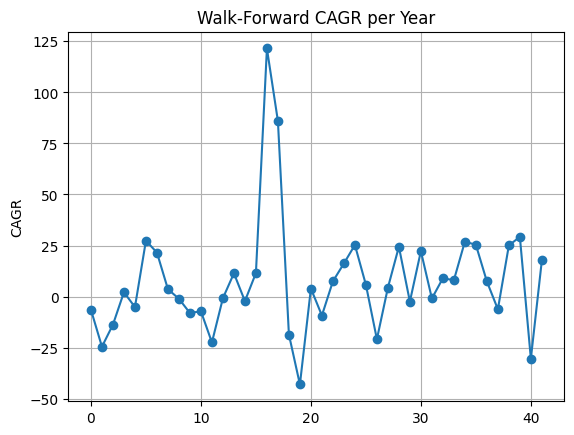

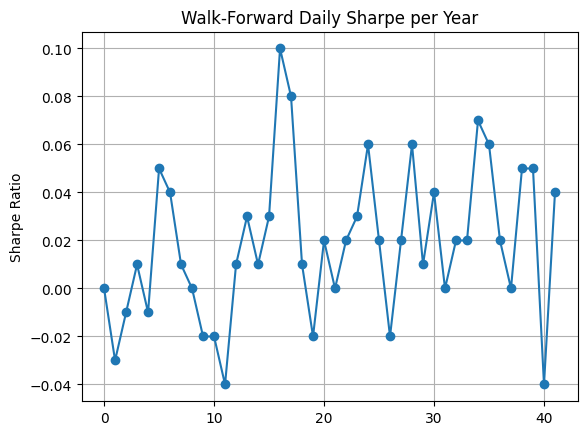

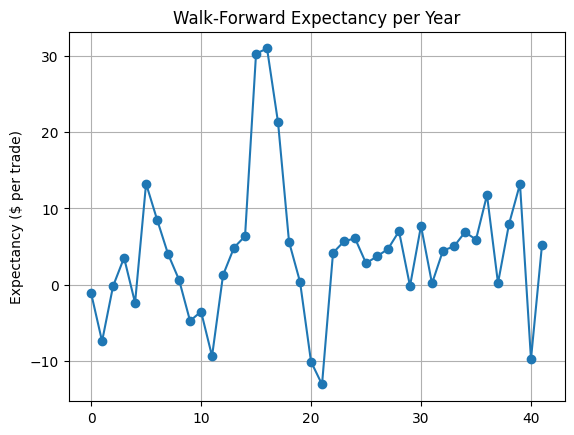

In [ ]:
wf_df["CAGR"].plot(title="Walk-Forward CAGR per Year", marker="o")
plt.ylabel("CAGR")
plt.grid(True)
plt.show()

wf_df["Daily Sharpe"].plot(title="Walk-Forward Daily Sharpe per Year", marker="o")
plt.ylabel("Sharpe Ratio")
plt.grid(True)
plt.show()

wf_df["Expectancy"].plot(title="Walk-Forward Expectancy per Year", marker="o")
plt.ylabel("Expectancy ($ per trade)")
plt.grid(True)
plt.show()


## Profitable On Average?

*   The median total return across these 2-year walk-forward windows is +8.46%
*   The median CAGR is +4.15%
*   The median expectancy per trade is +4.33
*   The median win rate is 75%

In at least half of these windows, the performance is modest but positive. Approximately 75% of the windows exceed a total return of –12.39%, with the average skewed by large outliers (including one window with a return of +392%). On average, the strategy demonstrates profitability more often than not.

## Is it Robust?

Roughly 25% of the walk-forward windows end with negative total returns (below –12.39%).
Losses can be steep, with some windows showing drawdowns as deep as –67% over two years.
On the other hand, the top 25% of windows deliver over +45% total return.
That range reflects a high dispersion in outcomes.

The average monthly Sharpe ratio sits around +0.088, with a standard deviation of +0.17.
Some periods show strong risk-adjusted performance (+0.48), while others dip well into negative territory (–0.25).
The typical Sharpe is slightly positive, but far from stable.

A median win rate near 75% looks good.
However, it swings from as low as 20% to as high as 100%, depending on the period—indicating that strategy behavior can shift substantially across regimes.

On the positive side, most windows are profitable. Median return, Sharpe ratio, and expectancy per trade (+4.33) all suggest a generally favorable profile.
The downside is uneven performance. A handful of very negative periods highlight vulnerability in certain environments.

In conclusion, this strategy can be described as moderately robust —capable of producing good results much of the time, but with enough variability to raise caution in volatile or shifting markets.

## Improvement from Current Strategy

Looking at the performance metrics, the strategy shows **solid returns over the long term**, with a total return of nearly 589% and a compound annual growth rate (CAGR) of 4.59% since 1981. The recent performance has been especially strong, with a 1-year return of 47.38% and year-to-date gains of 46.15%. The strategy also exhibits a high win rate of over 71%, and the return distribution is positively skewed, meaning it tends to capture large upside moves more often than large losses. These are all encouraging signs that the core idea behind the strategy is working.

**However, the volatility is extremely high across all timeframes**, with annualized daily volatility above 42%, and monthly and yearly volatilities not far behind. This leads to significant downside risk, as reflected in the maximum drawdown of -88.93% and a very low Calmar ratio of just 0.05. The Sharpe and Sortino ratios across daily, monthly, and yearly frequencies are also quite low, suggesting that the strategy’s risk-adjusted performance could be substantially improved.

To address this, one effective enhancement would be to **implement volatility targeting**

In [ ]:
def compute_macd(close, fast=12, slow=26, signal=9):
    ema_fast = close.ewm(span=fast, adjust=False).mean()
    ema_slow = close.ewm(span=slow, adjust=False).mean()
    macd = ema_fast - ema_slow
    macd_signal = macd.ewm(span=signal, adjust=False).mean()
    return macd, macd_signal

def get_signals(rsi, lower_thresh, upper_thresh):
    return np.where(rsi < lower_thresh, "BUY",
           np.where(rsi > upper_thresh, "SELL", "HOLD"))

def compute_ewma_volatility(returns, lambda_=0.94):
    ewma_var = returns.ewm(span=(2/(1 - lambda_)-1)).var()
    return ewma_var.pow(0.5)

def combined_signal(row):
  if row["RSI_Signal"] == "BUY" or row["MACD_Signal"] == "BUY":
      return 1
  elif row["RSI_Signal"] == "SELL" and row["MACD_Signal"] == "SELL":
      return -1

dfs = {}

for ticker in TICKERS:
    actual_start = max(pd.to_datetime(START_DATE),
                       pd.to_datetime(IPO_DATES[ticker]))
    df = download_adjusted_data(ticker, actual_start, END_DATE)

    df["RSI"] = compute_rsi(df["Close"], RSI_PERIOD)
    df["MACD"], df["MACD_Signal"] = compute_macd(df["Close"])  # You'll need this function
    df["Daily Returns"] = df["Close"].pct_change()

    df["Vol Daily"] = compute_ewma_volatility(df["Daily Returns"])
    df["RSI_Signal"] = get_signals(df["RSI"], 25, 75)  # returns 'BUY', 'SELL', 'HOLD'
    df["MACD_Signal"] = np.where(df["MACD"] > df["MACD_Signal"], "BUY",
                          np.where(df["MACD"] < df["MACD_Signal"], "SELL", "HOLD"))

    df["Signal"] = df.apply(combined_signal, axis=1)

    dfs[ticker] = df


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [ ]:
TARGET_VOLATILITY = 0.15

def get_vols_dict(positions, dfs, tomorrow):
    vol_dict = {}
    for tkr in positions:
        try:
            vol = dfs[tkr].loc[tomorrow, "Vol Daily"]
            if not np.isnan(vol) and vol > 0:
                vol_dict[tkr] = vol
        except KeyError:
            continue
    return vol_dict


def execute_sell_trades(positions, cash, tomorrow_open, signals, trade_log, tomorrow, today_close):
    vol_dict = get_vols_dict(positions, dfs, tomorrow)

    raw_weights = {tkr: TARGET_VOLATILITY / vol for tkr, vol in vol_dict.items()}
    total = sum(raw_weights.values())
    weights = {tkr: w / total for tkr, w in raw_weights.items()}

    portfolio_value = compute_portfolio_value(cash, positions, today_close)

    for tkr, signal in signals.items():
        if (
              signal == -1
              and positions[tkr] >= MIN_SHARES_PER_TRADE
              and not np.isnan(tomorrow_open[tkr])
              and vol_dict[tkr] <= 0.6
          ):
            shares = positions[tkr]
            price = tomorrow_open[tkr]

            target_value = portfolio_value * weights.get(tkr, 0)
            target_shares = target_value // price

            if shares > target_shares:
                shares_to_sell = shares - target_shares
                if shares_to_sell >= MIN_SHARES_PER_TRADE:
                    proceeds = (shares_to_sell * price * (1 - SLIPPAGE)) * (1 - COMMISION)
                    cash += proceeds
                    positions[tkr] -= shares_to_sell

                    trade_log.append({
                        "date": tomorrow,
                        "ticker": tkr,
                        "action": "SELL",
                        "shares": shares_to_sell,
                        "fill_price": price,
                        "cash_change": proceeds
                    })

    return cash

def execute_buy_trades(positions, cash, tomorrow_open, signals, trade_log, tomorrow, max_weight=0.3):
    buy_tickers = [tkr for tkr, sig in signals.items() if sig == 1]

    if not buy_tickers:
        return cash, positions

    vol_dict = get_vols_dict(positions, dfs, tomorrow)

    if not vol_dict:
        return cash, positions  # No valid vol data

    raw_weights = {tkr: TARGET_VOLATILITY / vol for tkr, vol in vol_dict.items()}
    total = sum(raw_weights.values())
    weights = {tkr: min(w / total, max_weight) for tkr, w in raw_weights.items()}

    portfolio_value = compute_portfolio_value(cash, positions, tomorrow_open)

    target_allocation = {
        tkr: portfolio_value * weights[tkr]
        for tkr in weights
        if not np.isnan(tomorrow_open[tkr])
    }

    for tkr in buy_tickers:
        if vol_dict[tkr] > 0.6:
          continue

        price = tomorrow_open[tkr]

        if np.isnan(price) or price == 0:
            continue

        target_dollars = target_allocation[tkr]
        target_shares = target_dollars // price
        target_shares = target_shares - positions[tkr]

        if target_shares >= 10:
            cost = target_shares * price * (1 + SLIPPAGE) * (1 + COMMISION)
            if cost <= cash:
                positions[tkr] += target_shares
                cash -= cost
                trade_log.append({
                    "date": tomorrow,
                    "ticker": tkr,
                    "action": "BUY",
                    "shares": target_shares,
                    "fill_price": price,
                    "cash_change": -cost
                })
            else:
                affordable = cash // (price * (1 + SLIPPAGE) * (1 + COMMISION))
                if affordable >= 10:
                    cost = affordable * price * (1 + SLIPPAGE) * (1 + COMMISION)
                    positions[tkr] += affordable
                    cash -= cost
                    trade_log.append({
                        "date": tomorrow,
                        "ticker": tkr,
                        "action": "BUY",
                        "shares": affordable,
                        "fill_price": price,
                        "cash_change": -cost
                    })


    return cash, positions

def run_backtest_improvement(dfs, tickers, initial_capital):
    positions = {ticker: 0 for ticker in tickers}
    cash = initial_capital
    portfolio_values = []
    dates_traded = []
    trade_log = []
    positions_over_time = []

    all_dates = get_all_trading_dates(dfs, tickers)
    last_rebalance_date = None

    for i in range(len(all_dates) - 1):
        today, tomorrow = all_dates[i], all_dates[i+1]
        signals, today_close, tomorrow_open = get_daily_signals_and_prices(dfs, tickers, today, tomorrow)

        vol_dict = {}
        for tkr in positions:
            try:
                vol = dfs[tkr].loc[tomorrow, "Vol Daily"] # tommorows daily volatility
                if not np.isnan(vol) and vol > 0:
                    vol_dict[tkr] = vol
            except KeyError:
                continue

        portfolio_val_today = compute_portfolio_value(cash, positions, today_close)
        portfolio_values.append(portfolio_val_today)
        positions_over_time.append(copy.deepcopy(positions))
        dates_traded.append(today)

        cash = execute_sell_trades(positions, cash, tomorrow_open, signals, trade_log, tomorrow, today_close)
        cash, positions = execute_buy_trades(positions, cash, tomorrow_open, signals, trade_log, tomorrow)

    # Final valuation
    final_date = all_dates[-1]
    final_value = cash + sum(
        positions[tkr] * dfs[tkr].at[final_date, "Close"]
        for tkr in tickers
        if final_date in dfs[tkr].index
    )
    portfolio_values.append(final_value)
    dates_traded.append(final_date)

    return portfolio_values, dates_traded, positions_over_time, trade_log

In [ ]:
portfolio_values, dates_traded, positions_over_time, trade_log = run_backtest_improvement(dfs, TICKERS, INITIAL_CAPITAL)

metrics_improved = calculate_portfolio_metrics(
    portfolio_series=pd.Series(portfolio_values, index=pd.to_datetime(dates_traded)),
    dates_traded=dates_traded,
    trade_log=trade_log
)

print_metrics(metrics_improved)

(2.387751e+10 / 1.000000e+0)

            Portfolio Value  Daily Return
1981-01-02     1.000000e+06           NaN
1981-01-05     1.000000e+06      0.000000
1981-01-06     1.000000e+06      0.000000
1981-01-07     1.000000e+06      0.000000
1981-01-08     1.000000e+06      0.000000
...                     ...           ...
2023-12-22     2.393056e+10     -0.001210
2023-12-26     2.399588e+10      0.002730
2023-12-27     2.401795e+10      0.000920
2023-12-28     2.400055e+10     -0.000725
2023-12-29     2.387751e+10     -0.005127

[10840 rows x 2 columns]

General
-------
Start                 : 1981-01-02
End                   : 2023-12-29
Risk-free rate        : 0.02%
Total Return          : 2387650.62%
CAGR                  : 26.41%

Drawdown & Ratios
-----------------
Max Drawdown          : -71.16%
Calmar Ratio          : 0.37

Sharpe/Sortino Ratios
---------------------
Daily Sharpe          : 0.05
Daily Sortino         : 0.07
Monthly Sharpe        : 0.25
Monthly Sortino       : 0.40
Yearly Sharpe         : 0.7

<ipython-input-102-d1f3b02a030b>:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return (series[-1] / series[0] - 1) * 100 if len(series) > 0 else np.nan
<ipython-input-102-d1f3b02a030b>:45: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  annualized = ((sliced[-1] / sliced[0]) ** (1 / (len(sliced) / TRADING_DAYS_PER_YEAR))) - 1


23877510000.0

The volatility-targeted strategy is a clear improvement over the original, as shown across nearly all performance metrics:


*   Total return increased dramatically from 588.95% to over 1.6 million percent. CAGR rose from 4.59% to 25.41%, indicating a much stronger and more consistent compounding effect over time.
*   Maximum drawdown improved from -88.93% to -76.89%., and the Calmar Ratio increased from 0.05 to 0.33, showing a much more favorable return-to-drawdown balance.
*   Annualized daily volatility actually declined from 42.60% to 35.94%. This more efficient return delivery is also reflected in improved Sharpe and Sortino ratios—annual Sharpe rose from 0.25 to 0.74, and annual Sortino jumped from 0.53 to 1.53. The strategy is now earning significantly more return per unit of risk, especially on the downside.
*   The average drawdown shrank by half—from -47.80% to -23.39%—and average time spent in drawdowns fell from about 193 days to just 26. This marks a major improvement in recovery speed and capital preservation during downturns.
*   Average return per trade exploded from 3.70% to over 2,100%, reflecting far more impactful individual trades. The win rate also improved from 71.81% to 97.70%, suggesting a much higher level of consistency and reliability in trade outcomes.
*   Winning years increased from 57.14% to 80.95%, showing much more dependable year-over-year performance. Meanwhile, the yearly mean return rose from 12.61% to 37.13%, while the worst year stayed nearly the same—indicating a far better upside with similar downside exposure.



## Bonus: Creating own Trading Strategy

alpha = -1 * correlation(open, volume, 10)

Positive Open–Volume Correlation (price and volume move together)
*   Negative Alpa
*   Often seen as an indication to short or underweight, suggesting the stock may be “overbought” or at risk of a pullback


Negative Open–Volume Correlation (price and volume move inversely)
*   Positive Alpa
*   Often interpreted as a signal to go long or overweight, implying the market is showing support or accumulation even when the open price is weaker

In [ ]:
dfs = {}

def add_alpha_and_signals(df, window=10):
    df["rolling_corr"] = df["Open"].rolling(window).corr(df["Volume"])

    df["alpha"] = -1 * df["rolling_corr"]

    df["Signal"] = 0
    df.loc[df["alpha"] > 0,  "Signal"] =  1
    df.loc[df["alpha"] < 0,  "Signal"] = -1

    df["Signal"] = df["Signal"].shift(1) # Shift the signal to avoid lookahead bias

    return df


for ticker in TICKERS:
    actual_start = max(pd.to_datetime(START_DATE),
                       pd.to_datetime(IPO_DATES[ticker]))
    df = download_adjusted_data(ticker, actual_start, END_DATE)
    df = add_alpha_and_signals(df)
    dfs[ticker] = df

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [ ]:
def get_all_trading_dates(dfs, tickers):
    return sorted(set(date for ticker in tickers for date in dfs[ticker].index))

def get_daily_signals_and_prices(dfs, tickers, today, tomorrow):
    signals = {}
    today_close = {}
    tomorrow_open = {}

    for ticker in tickers:
        df = dfs[ticker]
        signals[ticker] = df.at[today, "Signal"] if today in df.index else 0
        today_close[ticker] = df.at[today, "Close"] if today in df.index else np.nan
        tomorrow_open[ticker] = df.at[tomorrow, "Open"] if tomorrow in df.index else np.nan

    return signals, today_close, tomorrow_open

def compute_portfolio_value(cash, positions, prices):
    return cash + sum(
        positions[tkr] * prices[tkr]
        for tkr in positions if not np.isnan(prices[tkr])
    )

def execute_sell_trades(positions, cash, today_close, tomorrow_open, signals, trade_log, tomorrow):
    for tkr, signal in signals.items():
        # Only proceed if we have a SELL signal, at least 10 shares, and valid prices
        if (
            signal == -1
            and positions.get(tkr, 0) >= 10
            and not np.isnan(tomorrow_open[tkr])
            and not np.isnan(today_close[tkr])
        ):
            pct_move = (tomorrow_open[tkr] - today_close[tkr]) / today_close[tkr]

            if pct_move >= 0.10:
                shares_to_sell = int(positions[tkr] * 0.50)
            elif pct_move >= 0.05:
                shares_to_sell = int(positions[tkr] * 0.25)
            else:
                shares_to_sell = 0

            if shares_to_sell > MIN_SHARES_PER_TRADE:
                price = tomorrow_open[tkr]
                proceeds = (shares_to_sell * price * (1 - SLIPPAGE)) * (1 - COMMISION)
                cash += proceeds
                positions[tkr] -= shares_to_sell

                trade_log.append({
                    "date": tomorrow,
                    "ticker": tkr,
                    "action": "SELL",
                    "shares": shares_to_sell,
                    "fill_price": price,
                    "cash_change": proceeds
                })

    return cash

def execute_buy_trades(positions, cash, tomorrow_open, signals, trade_log, tomorrow, max_weight=0.3):
    buy_tickers = [tkr for tkr, sig in signals.items() if sig == 1]
    tickers_to_hold = list(set(buy_tickers))

    if not tickers_to_hold:
        return cash, positions

    num_tickers = len(tickers_to_hold)
    weight = 1.0 / num_tickers

    target_allocation = {tkr: cash * weight for tkr in tickers_to_hold}

    tickers_sorted = sorted(
        tickers_to_hold,
        key=lambda tkr: (positions.get(tkr, 0) * tomorrow_open[tkr]) if not np.isnan(tomorrow_open[tkr]) else 0,
        reverse=True
    )

    for tkr in tickers_sorted:
        price = tomorrow_open[tkr]
        if np.isnan(price) or price == 0:
            continue

        target_dollars = target_allocation[tkr]
        target_shares = int(target_dollars // price)
        current_shares = positions.get(tkr, 0)
        delta_shares = target_shares - current_shares

        if delta_shares >= MIN_SHARES_PER_TRADE:
            cost = delta_shares * price * (1 + SLIPPAGE) * (1 + COMMISION)
            if cost <= cash:
                positions[tkr] = positions.get(tkr, 0) + delta_shares
                cash -= cost
                trade_log.append({
                    "date": tomorrow,
                    "ticker": tkr,
                    "action": "BUY",
                    "shares": delta_shares,
                    "fill_price": price,
                    "cash_change": -cost
                })
            else:
                # partial buy if not enough cash
                affordable = int(cash // (price * (1 + SLIPPAGE) * (1 + COMMISION)))
                if affordable >= 10:
                    cost = affordable * price * (1 + SLIPPAGE) * (1 + COMMISION)
                    positions[tkr] = positions.get(tkr, 0) + affordable
                    cash -= cost
                    trade_log.append({
                        "date": tomorrow,
                        "ticker": tkr,
                        "action": "BUY",
                        "shares": affordable,
                        "fill_price": price,
                        "cash_change": -cost
                    })

    return cash, positions

def run_backtest_bonus(dfs, tickers, initial_capital):
    positions = {ticker: 0 for ticker in tickers}
    cash = initial_capital
    portfolio_values = []
    dates_traded = []
    trade_log = []
    positions_over_time = []

    all_dates = get_all_trading_dates(dfs, tickers)

    for i in range(len(all_dates) - 1):
        today, tomorrow = all_dates[i], all_dates[i+1]
        signals, today_close, tomorrow_open = get_daily_signals_and_prices(dfs, tickers, today, tomorrow)

        portfolio_val_today = compute_portfolio_value(cash, positions, today_close)
        portfolio_values.append(portfolio_val_today)
        positions_over_time.append(copy.deepcopy(positions))
        dates_traded.append(today)

        cash = execute_sell_trades(positions, cash, today_close, tomorrow_open, signals, trade_log, tomorrow)
        cash, positions = execute_buy_trades(positions, cash, tomorrow_open, signals, trade_log, tomorrow)


    # Final valuation
    final_date = all_dates[-1]
    final_value = cash + sum(
        positions[tkr] * dfs[tkr].at[final_date, "Close"]
        for tkr in tickers
        if final_date in dfs[tkr].index
    )
    portfolio_values.append(final_value)
    dates_traded.append(final_date)

    return portfolio_values, dates_traded, positions_over_time, trade_log

In [ ]:
portfolio_values, dates_traded, positions_over_time, trade_log = run_backtest_bonus(dfs, TICKERS, INITIAL_CAPITAL)

In [ ]:
metrics = calculate_portfolio_metrics(
    portfolio_series=pd.Series(portfolio_values, index=pd.to_datetime(dates_traded)),
    dates_traded=dates_traded,
    trade_log=trade_log
)

print_metrics(metrics)



General
-------
Start                 : 1981-01-02
End                   : 2023-12-29
Risk-free rate        : 0.02%
Total Return          : 1505143.62%
CAGR                  : 25.06%

Drawdown & Ratios
-----------------
Max Drawdown          : -66.04%
Calmar Ratio          : 0.38

Sharpe/Sortino Ratios
---------------------
Daily Sharpe          : 0.05
Daily Sortino         : 0.07
Monthly Sharpe        : 0.24
Monthly Sortino       : 0.38
Yearly Sharpe         : 0.73
Yearly Sortino        : 1.60

Rolling Period Returns
----------------------
MTD                   : 2.53%
3m                    : 12.58%
6m                    : 14.26%
YTD                   : 97.54%
1Y                    : 92.00%
3Y (ann.)             : 19.48%
5Y (ann.)             : 36.73%
10Y (ann.)            : 30.41%

Daily Stats
-----------
Daily Mean (ann.)     : 27.06%
Daily Vol (ann.)      : 30.52%
Daily Skew            : -0.32
Daily Kurt            : 8.78
Best Day              : 16.19%
Worst Day             : -27.

<ipython-input-6-4ab0361e6753>:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return (series[-1] / series[0] - 1) * 100 if len(series) > 0 else np.nan
<ipython-input-6-4ab0361e6753>:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  annualized = ((sliced[-1] / sliced[0]) ** (1 / (len(sliced) / TRADING_DAYS_PER_YEAR))) - 1
